Training with n_embd=64, n_head=4, n_layer=4, dropout=0.0
Step: 0, Train Loss: 4.170563220977783, Val Loss: 4.1703782081604
Step: 10, Train Loss: 3.4570000171661377, Val Loss: 3.484973669052124
Step: 20, Train Loss: 3.2888379096984863, Val Loss: 3.322129726409912
Step: 30, Train Loss: 3.177813768386841, Val Loss: 3.213183641433716
Step: 40, Train Loss: 3.0336413383483887, Val Loss: 3.059706449508667
Training with n_embd=128, n_head=8, n_layer=8, dropout=0.1
Step: 0, Train Loss: 3.743056535720825, Val Loss: 3.7657294273376465
Step: 10, Train Loss: 3.225714921951294, Val Loss: 3.2567801475524902
Step: 20, Train Loss: 2.9585986137390137, Val Loss: 2.9875192642211914
Step: 30, Train Loss: 2.7992382049560547, Val Loss: 2.7932910919189453
Step: 40, Train Loss: 2.700653076171875, Val Loss: 2.7060375213623047
Training with n_embd=32, n_head=2, n_layer=2, dropout=0.2
Step: 0, Train Loss: 4.2610321044921875, Val Loss: 4.269811153411865
Step: 10, Train Loss: 3.8691928386688232, Val Loss: 3.882983

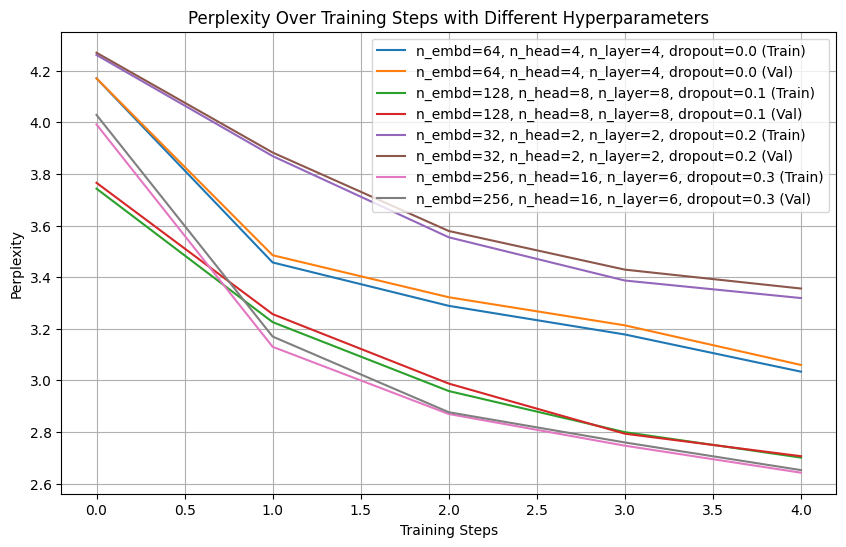

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set up hyperparameters
batch_size = 16
block_size = 32
max_iters = 50
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

# Hyperparameters to modify
hyperparameters = [
    {'n_embd': 64, 'n_head': 4, 'n_layer': 4, 'dropout': 0.0},
    {'n_embd': 128, 'n_head': 8, 'n_layer': 8, 'dropout': 0.1},
    {'n_embd': 32, 'n_head': 2, 'n_layer': 2, 'dropout': 0.2},
    {'n_embd': 256, 'n_head': 16, 'n_layer': 6, 'dropout': 0.3}
]

# Load data and create train and test datasets
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
# Define components of the Decoder block
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
# Define the LanguageModel class
class LanguageModel(nn.Module):
    def __init__(self, n_embd, n_head, n_layer):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

class Head(nn.Module):
    def __init__(self, head_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class LanguageModel(nn.Module):
    def __init__(self, n_embd, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head, dropout=dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.dropout(x)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Define the training loop
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Train the model with different hyperparameters
train_losses_list = []
val_losses_list = []

for params in hyperparameters:
    n_embd = params['n_embd']
    n_head = params['n_head']
    n_layer = params['n_layer']
    dropout = params['dropout']

    print(f"Training with n_embd={n_embd}, n_head={n_head}, n_layer={n_layer}, dropout={dropout}")
    
    model = LanguageModel(n_embd=n_embd, n_head=n_head, n_layer=n_layer, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for step in range(max_iters):
        optimizer.zero_grad()
        X, Y = get_batch('train')
        logits, loss = model(X, Y)
        loss.backward()
        optimizer.step()

        if step % eval_interval == 0:
            train_loss, val_loss = estimate_loss().values()
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f'Step: {step}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)

# Plotting perplexity for each set of hyperparameters
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, params in enumerate(hyperparameters):
    n_embd = params['n_embd']
    n_head = params['n_head']
    n_layer = params['n_layer']
    dropout = params['dropout']

    plt.plot(train_losses_list[i], label=f"n_embd={n_embd}, n_head={n_head}, n_layer={n_layer}, dropout={dropout} (Train)")
    plt.plot(val_losses_list[i], label=f"n_embd={n_embd}, n_head={n_head}, n_layer={n_layer}, dropout={dropout} (Val)")

plt.title("Perplexity Over Training Steps with Different Hyperparameters")
plt.xlabel("Training Steps")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
The perplexity gradually decreased as the model was trained, indicating an improvement in its ability to predict the next characters in the text data 
over the course of training.